In [0]:
# Pairplot using seaborn
!pip install seaborn

# Some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2dhi6vjm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-2dhi6vjm
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.076b63aab4868862a8888bbeed07881fb0e5cf1d7_-cp36-none-any.whl size=100468 sha256=44ec148535dc0829a31aa0d40fac942f40f77df45ac2e4d95ca38a21f7f2f1b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jpd50eae/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Fetching data from The auto MPG dataset

In [0]:
datasetPath = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datasetPath

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

Using pandas import it

In [0]:
columnNames = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
rawDataset = pd.read_csv(datasetPath, names=columnNames,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = rawDataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Now Clean the data

Check Unknown values contains in dataset

In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Dropping that rows for continue

In [0]:
dataset = dataset.dropna()

The column "Origin" is non-numeric , convert that to one-*hot*

In [0]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [0]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1



# Split the data into train and test

 Now the dataset split into a training set and a test set.

 for the final evaluation of our model, We will use the test set.



In [0]:
trainDataset = dataset.sample(frac=0.8,random_state=0)
testDataset = dataset.drop(trainDataset.index)

# Now Inspect the data

from the training set we need quick look at the joint distribution of a few pairs of columns

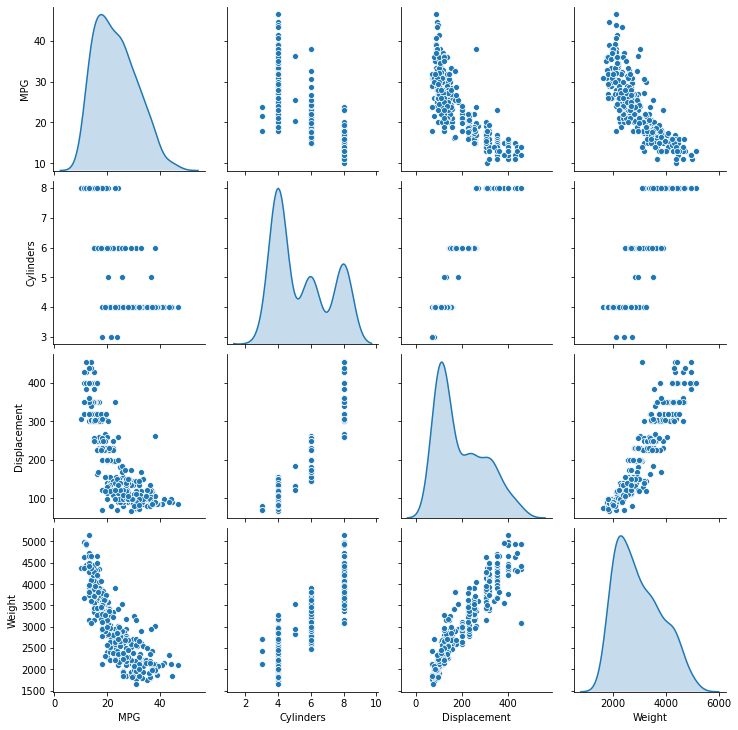

In [0]:
sns.pairplot(trainDataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Need to look overall statistics :

In [0]:
trainStats = trainDataset.describe()
trainStats.pop("MPG")
trainStats = trainStats.transpose()
trainStats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


# Split features from labels

This label is the value that you will train the model to predict.

In [0]:
trainLabels = trainDataset.pop('MPG')
testLabels = testDataset.pop('MPG')

## Normalize the data

In [0]:
def norm(x):
  return (x - trainStats['mean']) / trainStats['std']
normedTrainData = norm(trainDataset)
normedTestData = norm(testDataset)

 now normalized data we will use to train the model.

## Build the model

Here, we will use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. 
This model building steps are wrapped in a function, buildModel

In [0]:
def buildModel():
  modelOne = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(trainDataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  modelOne.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return modelOne


In [0]:
modelOne = buildModel()

# Inspect the model

 `.summary` method use to print a simple description of the model

In [0]:
modelOne.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now Take a batch of 5 examples from the training data and call model.predict on it.

In [0]:
exampleBatch = normedTrainData[:5]
exampleResult = modelOne.predict(exampleBatch)
exampleResult

array([[-0.26967666],
       [-0.1372215 ],
       [-0.6730652 ],
       [-0.11647345],
       [-0.5251156 ]], dtype=float32)

# Train the model

 For 500 epochs Train the model, and record the training and validation accuracy in the `history` object.

In [0]:
EPOCHS = 500

history = modelOne.fit(
  normedTrainData, trainLabels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:592.5540,  mae:23.0905,  mse:592.5540,  val_loss:591.6298,  val_mae:23.0442,  val_mse:591.6298,  
....................................................................................................
Epoch: 100, loss:5.7153,  mae:1.6902,  mse:5.7153,  val_loss:8.5299,  val_mae:2.2385,  val_mse:8.5299,  
....................................................................................................
Epoch: 200, loss:5.3077,  mae:1.6097,  mse:5.3077,  val_loss:7.9294,  val_mae:2.1954,  val_mse:7.9294,  
....................................................................................................
Epoch: 300, loss:4.7384,  mae:1.4821,  mse:4.7384,  val_loss:7.7757,  val_mae:2.1148,  val_mse:7.7757,  
....................................................................................................
Epoch: 400, loss:4.1396,  mae:1.3873,  mse:4.1396,  val_loss:8.0443,  val_mae:2.2300,  val_mse:8.0443,  
..............................................................

Now Visualize the model's training progress using the stats stored in the history object.

In [0]:
histo = pd.DataFrame(history.history)
histo['epoch'] = history.epoch
histo.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,3.735071,1.307308,3.735071,8.069592,2.240191,8.069592,495
496,3.878245,1.317203,3.878245,7.825406,2.162122,7.825406,496
497,3.817486,1.319603,3.817486,8.021894,2.240114,8.021894,497
498,3.945009,1.333822,3.945009,8.179257,2.184469,8.179257,498
499,3.934623,1.340665,3.934623,8.044517,2.247556,8.044517,499


In [0]:
ploter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

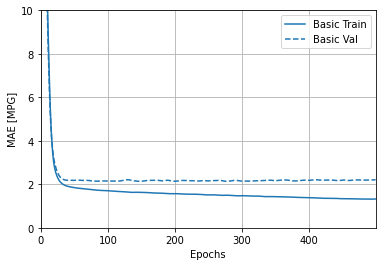

In [0]:
ploter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

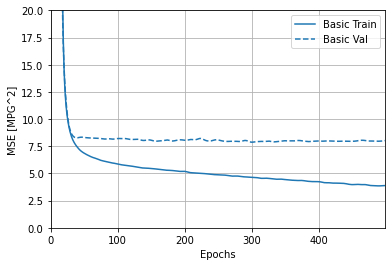

In [0]:
ploter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

Graph shows some improvement, or even degradation in the validation error after about 100 epochs. Need to update the modelOne.fit

In [0]:
modelOne = buildModel()

earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

earlyHistory = modelOne.fit(normedTrainData, trainLabels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[earlyStop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:582.9926,  mae:22.9093,  mse:582.9926,  val_loss:575.0157,  val_mae:22.6363,  val_mse:575.0157,  
............................................................

Text(0, 0.5, 'MAE [MPG]')

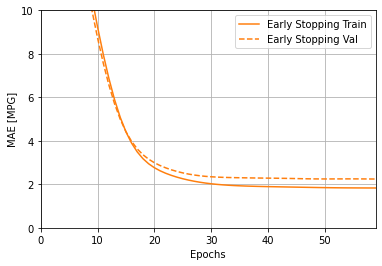

In [0]:
ploter.plot({'Early Stopping': earlyHistory}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that, the average error is usually around +/- 2 MPG

 Now for model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [0]:
loss, ma, ms = modelOne.evaluate(normedTestData, testLabels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(ma))

3/3 - 0s - loss: 6.4892 - mae: 1.9941 - mse: 6.4892
Testing set Mean Abs Error:  1.99 MPG


# Make predictions

Last, predict MPG values using data in the testing set:

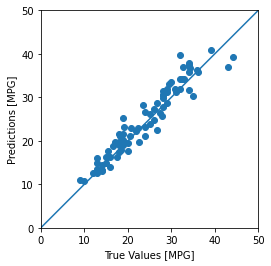

In [0]:
testPredi = modelOne.predict(normedTestData).flatten()

a = plt.axes(aspect='equal')
plt.scatter(testLabels, testPredi)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

model predicts reasonably well, now  look at the error distribution.

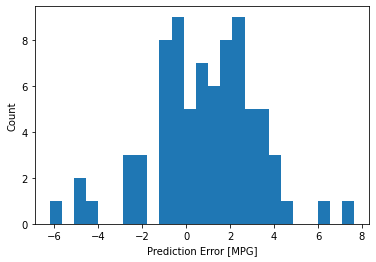

In [0]:
err = testPredi - testLabels
plt.hist(err, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")